# Pedestrian Attribute Recognition & People Analytics

## Objective
The objective of this project is to develop a real-time pedestrian attribute analysis system
that automatically extracts demographic and appearance-based information from images.

## Applications
- Retail analytics (customer demographics & behavior)
- Smart surveillance
- Smart city pedestrian analysis

The system performs:
- Pedestrian attribute recognition
- Confidence-based output screening
- Visual interpretation of results


In [1]:
import os
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision import models, transforms

from config import *
from screening import ATTRIBUTE_THRESHOLDS


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(SELECTED_ATTRS))

checkpoint = torch.load(
    "peta_resnet18_attributes.pth",
    map_location=device,
    weights_only=True
)

model.load_state_dict(checkpoint["model_state"])
model.to(device)
model.eval()

print("Model loaded successfully")


Model loaded successfully


In [4]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


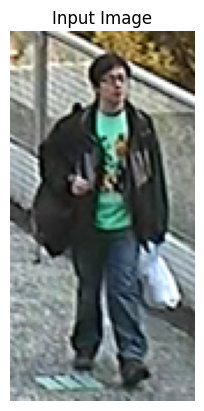

Image used: E:\people-analytics\data\PETA\PETA dataset\CUHK\archive\2445.png


In [14]:
image_files = os.listdir(IMAGE_DIR)
image_path = os.path.join(IMAGE_DIR, random.choice(image_files))

image = Image.open(image_path).convert("RGB")

plt.imshow(image)
plt.axis("off")
plt.title("Input Image")
plt.show()

print("Image used:", image_path)


In [15]:
input_tensor = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    logits = model(input_tensor)
    probs = torch.sigmoid(logits).squeeze(0)


In [16]:
screened_attributes = []

for i, attr in enumerate(SELECTED_ATTRS):
    if probs[i].item() >= ATTRIBUTE_THRESHOLDS[attr]:
        screened_attributes.append(
            f"{attr} ({probs[i].item():.2f})"
        )

screened_attributes


['personalMale (0.90)',
 'personalLess30 (0.96)',
 'upperBodyCasual (0.98)',
 'carryingBackpack (0.97)']

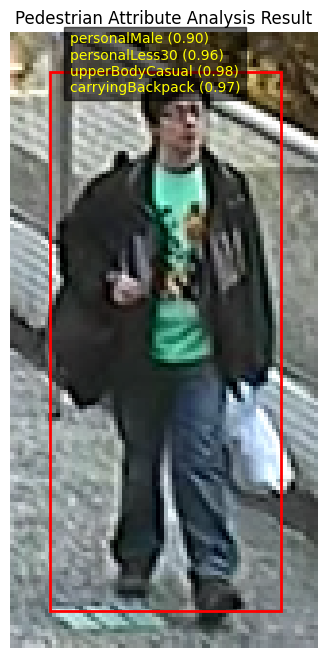

In [17]:
fig, ax = plt.subplots(1, figsize=(6, 8))
ax.imshow(image)
ax.axis("off")

# Dummy bounding box (PETA images are cropped pedestrians)
box = patches.Rectangle(
    (10, 10),
    image.size[0] - 20,
    image.size[1] - 20,
    linewidth=2,
    edgecolor="red",
    facecolor="none"
)

ax.add_patch(box)

label_text = "\n".join(screened_attributes)

ax.text(
    15, 15,
    label_text,
    color="yellow",
    fontsize=10,
    bbox=dict(facecolor="black", alpha=0.6)
)

plt.title("Pedestrian Attribute Analysis Result")
plt.show()


In [18]:
!pip install ultralytics

  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
  Using cached pyyaml-6.0.3-cp312-cp312-win_amd64.whl.metadata (2.4 kB)
  Using cached numpy-2.2.6-cp312-cp312-win_amd64.whl.metadata (60 kB)
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ------------------ --------------------- 0.5/1.2 MB 1.5 MB/s eta 0:00:01
   ------------------ --------------------- 0.5/1.2 MB 1.5 MB/s eta 0:00:01
   --------------------------- ------------ 0.8/1.2 MB 1.1 MB/s eta 0:00:01
   --------------------------- ------------ 0.8/1.2 MB 1.1 MB/s eta 0:00:01
   ---------------------------------------- 1.2/1.2 MB 964.3 kB/s  0:00:01
Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl (39.0 MB)
Using cached numpy-2.2.6-cp312-cp312-win_amd64.whl (12.6 MB)
   ---------------------------------------- 0.0/802.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/802.4 kB ?

  You can safely remove it manually.
  You can safely remove it manually.


In [20]:
from ultralytics import YOLO
import numpy as np


Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\manon\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [21]:
yolo_model = YOLO("yolov8n.pt")
print("YOLO model loaded")


YOLO model loaded


In [22]:
# Run detection
results = yolo_model(image)

# Extract person boxes
boxes = []
for r in results:
    for box in r.boxes:
        cls = int(box.cls[0])
        if cls == 0:  # person
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            boxes.append([int(x1), int(y1), int(x2), int(y2)])

print(f"Detected {len(boxes)} person(s)")



0: 640x320 1 person, 132.0ms
Speed: 2.1ms preprocess, 132.0ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 320)
Detected 1 person(s)


In [23]:
person_crops = []

for (x1, y1, x2, y2) in boxes:
    crop = image.crop((x1, y1, x2, y2))
    person_crops.append((x1, y1, x2, y2, crop))

len(person_crops)


1

In [24]:
all_person_results = []

for (_, _, _, _, crop) in person_crops:
    input_tensor = transform(crop).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(input_tensor)
        probs = torch.sigmoid(logits).squeeze(0)

    attrs = []
    for i, attr in enumerate(SELECTED_ATTRS):
        if probs[i].item() >= ATTRIBUTE_THRESHOLDS[attr]:
            attrs.append(f"{attr} ({probs[i].item():.2f})")

    all_person_results.append(attrs)


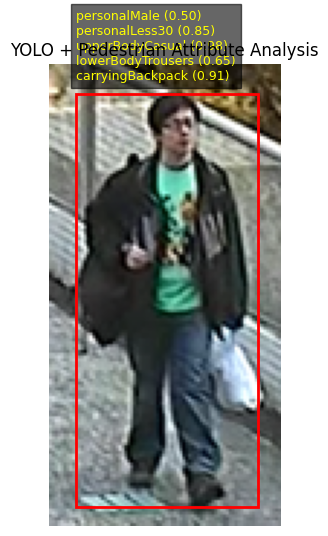

In [25]:
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.imshow(image)
ax.axis("off")

for (x1, y1, x2, y2, _), attrs in zip(person_crops, all_person_results):
    # Draw box
    rect = patches.Rectangle(
        (x1, y1),
        x2 - x1,
        y2 - y1,
        linewidth=2,
        edgecolor="red",
        facecolor="none"
    )
    ax.add_patch(rect)

    text = "\n".join(attrs)
    ax.text(
        x1,
        y1 - 5,
        text,
        color="yellow",
        fontsize=9,
        bbox=dict(facecolor="black", alpha=0.6)
    )

plt.title("YOLO + Pedestrian Attribute Analysis")
plt.show()
